In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import sys
import os
# FOLDERNAME = "20-21/Spring Quarter/CS 197/CS197/cs197"
# FOLDERNAME = "CS197/cs197/"
FOLDERNAME = "3_SPR/cs197/fewshot-code"
%cd /content/drive/My\ Drive/$FOLDERNAME

BASE = os.path.join('/content/drive/My Drive', FOLDERNAME)
sys.path.append(BASE)

/content/drive/My Drive/3_SPR/cs197/fewshot-code


In [3]:
#@title
%reload_ext autoreload
%autoreload 2
! pip install ftfy regex
! wget https://openaipublic.azureedge.net/clip/bpe_simple_vocab_16e6.txt.gz -O bpe_simple_vocab_16e6.txt.gz
!apt install libomp-dev
!pip install faiss-gpu

import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

from collections import OrderedDict
import IPython.display
import itertools
import os
from tqdm.notebook import tqdm

from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import skimage #Has some images in here - check original "Interacting with CLIP.ipynb" document
import torch
from torch.utils.data import DataLoader

import faiss
from faissKNeighbors import FaissKNeighbors
from prototype import Prototype
from prototypevector import PrototypeVector
from torchvision.datasets import CIFAR10, CIFAR100
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from utils.data_utils import *
from utils.image_utils import *
from utils.text_utils import *
from linear_classifier import *

print("Torch version:", torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_theme(style="whitegrid")

plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

     |████████████████████████████████| 71kB 9.2MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-cp37-none-any.whl size=41916 sha256=794c9f9e102bf0aad1dab5ce3b6bb7bcced20f754e9306c3233e428251579628
  Stored in directory: /root/.cache/pip/wheels/99/2c/e6/109c8a28fef7a443f67ba58df21fe1d0067ac3322e75e6b0b7
Successfully built ftfy
--2021-05-26 20:27:51--  https://openaipublic.azureedge.net/clip/bpe_simple_vocab_16e6.txt.gz
Resolving openaipublic.azureedge.net (openaipublic.azureedge.net)... 13.107.246.40, 13.107.213.40, 2620:1ec:bdf::40, ...
Connecting to openaipublic.azureedge.net (openaipublic.azureedge.net)|13.107.246.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1356917 (1.3M) [application/octet-stream]
Saving to: ‘bpe_simple_vocab_16e6.txt.gz’

bpe_simple_vocab_16 100%[===================>]   1.29M  --.-KB/s    in 0.02s   

2021-05-26 20:28:01 (58.1 MB/s) - ‘bpe_simple_vocab_16e6.txt.gz’ saved [1356917/1356917]

Reading package lists... Done
Building 

In [4]:
#@title
MODELS = {
    "RN50": "https://openaipublic.azureedge.net/clip/models/afeb0e10f9e5a86da6080e35cf09123aca3b358a0c3e3b6c78a7b63bc04b6762/RN50.pt",
    "RN101": "https://openaipublic.azureedge.net/clip/models/8fa8567bab74a42d41c5915025a8e4538c3bdbe8804a470a72f30b0d94fab599/RN101.pt",
    "RN50x4": "https://openaipublic.azureedge.net/clip/models/7e526bd135e493cef0776de27d5f42653e6b4c8bf9e0f653bb11773263205fdd/RN50x4.pt",
    "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",    
}
model_dir = os.path.join(BASE, "model.pt")
# ! wget {MODELS["ViT-B/32"]} -O model.pt

clip_model = torch.jit.load(model_dir).cuda().eval()
input_resolution = clip_model.input_resolution.item()
context_length = clip_model.context_length.item()
vocab_size = clip_model.vocab_size.item()

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in clip_model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [10]:
from torchvision.transforms import Compose, Normalize, Resize, ToTensor
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

DATASETS_DIR = os.path.join(BASE, 'datasets')
train_dataset_raw = CIFAR10(DATASETS_DIR, train=True, transform=ToTensor())
loader = DataLoader(train_dataset_raw, batch_size=len(train_dataset_raw))
images, _ = next(iter(loader))
image_mean, image_std = images.mean(), images.std()

In [14]:
train_dataset = CIFAR10(DATASETS_DIR, train=True, transform=Compose([ToTensor(), Normalize(image_mean, image_std), Resize(224) ]))
test_dataset = CIFAR10(DATASETS_DIR, train=False, transform=Compose([ToTensor(), Normalize(image_mean, image_std), Resize(224) ]))
test_vectors, test_labels = encodeDataset(test_dataset, clip_model.encode_image, device=device, batch_size=512)
train_vectors, train_labels = encodeDataset(train_dataset, clip_model.encode_image, device=device, batch_size=512)

In [27]:
print (test_vectors.device)

cpu


# Linear classifier experiments

In [55]:
def run_experiments(train_vectors, train_labels, test_vectors, test_labels, k_min, k_max, trials_per_k):
  accuracies = {}
  stds = {}
  for k in tqdm(range(k_min, k_max + 1), desc="k"):
    trial_accs = []
    for t in tqdm(range(trials_per_k), desc="trials"):
      train_data_dict = sample_classes(train_vectors, train_labels, per_class = k)

      lc_train_vectors = list(map(lambda c: torch.stack(random.sample(list(train_data_dict[c]), k)), range(10)))
      lc_train_vectors = torch.cat(lc_train_vectors)
      lc_train_labels = torch.tensor(list(range(10))).unsqueeze(1).expand(-1, k).flatten()

      classifier = linear_classifier(lc_train_vectors, lc_train_labels, 10, epochs=1000, lr=1e-1, device=device, print_every = 0).to(device)

      with torch.no_grad():
        pred_scores = classifier(test_vectors.to(device)).cpu()
      preds = torch.argmax(pred_scores, dim=1)
      test_acc = torch.mean((preds == test_labels).float())
      # print("k = {}, acc = {}".format(k, test_acc))
      trial_accs.append(test_acc)
    
    accuracies[k] = np.mean(trial_accs)
    stds[k] = np.std(trial_accs)

    print("k = {}, mean acc = {}, mean std = {}".format(k, accuracies[k], stds[k]))
  
  return accuracies, stds

In [56]:
accuracies, stds = run_experiments(train_vectors, train_labels, test_vectors, test_labels, 1, 50, 10)


k = 1, mean acc = 0.5957399606704712, mean std = 0.05227131024003029



k = 2, mean acc = 0.7274099588394165, mean std = 0.02398909255862236



k = 3, mean acc = 0.7714800238609314, mean std = 0.02998509258031845



k = 4, mean acc = 0.81836998462677, mean std = 0.012381190434098244



k = 5, mean acc = 0.8342800140380859, mean std = 0.013486054725944996



k = 6, mean acc = 0.8408799171447754, mean std = 0.004900156054645777



k = 7, mean acc = 0.850629985332489, mean std = 0.010931432247161865



k = 8, mean acc = 0.8555999994277954, mean std = 0.01183443982154131



k = 9, mean acc = 0.8568399548530579, mean std = 0.006727276369929314



k = 10, mean acc = 0.8549998998641968, mean std = 0.007844234816730022



k = 11, mean acc = 0.8613499402999878, mean std = 0.006679557729512453



k = 12, mean acc = 0.8643900156021118, mean std = 0.007179337088018656



k = 13, mean acc = 0.8718600273132324, mean std = 0.006141529884189367



k = 14, mean acc = 0.8694700002670288, mean std = 0.007062728516757488



k = 15, mean acc = 0.8692200779914856, mean std = 0.007113334257155657



k = 16, mean acc = 0.8729699850082397, mean std = 0.004877927713096142



k = 17, mean acc = 0.8720399737358093, mean std = 0.005034320987761021



k = 18, mean acc = 0.8739399909973145, mean std = 0.00708862254396081



k = 19, mean acc = 0.8740700483322144, mean std = 0.005280532408505678



k = 20, mean acc = 0.8761499524116516, mean std = 0.00467167142778635



k = 21, mean acc = 0.8751200437545776, mean std = 0.004092864226549864



k = 22, mean acc = 0.8755199313163757, mean std = 0.0045820982195436954



k = 23, mean acc = 0.8792999982833862, mean std = 0.004223506897687912



k = 24, mean acc = 0.8780099749565125, mean std = 0.006448638159781694



k = 25, mean acc = 0.8810299634933472, mean std = 0.006358625832945108



k = 26, mean acc = 0.8809000253677368, mean std = 0.003841348458081484



k = 27, mean acc = 0.8826200366020203, mean std = 0.004590384196490049



k = 28, mean acc = 0.8834199905395508, mean std = 0.003827217500656843



k = 29, mean acc = 0.8859699964523315, mean std = 0.004105623811483383



k = 30, mean acc = 0.8819600343704224, mean std = 0.004108327440917492



k = 31, mean acc = 0.8853200078010559, mean std = 0.004799964372068644



k = 32, mean acc = 0.8853200078010559, mean std = 0.005996300373226404



k = 33, mean acc = 0.8837900161743164, mean std = 0.004730842541903257



k = 34, mean acc = 0.8827099800109863, mean std = 0.003357219509780407



k = 35, mean acc = 0.8873799443244934, mean std = 0.005254289135336876



k = 36, mean acc = 0.8878200650215149, mean std = 0.004022133070975542



k = 37, mean acc = 0.8849300146102905, mean std = 0.00489715114235878



k = 38, mean acc = 0.8838800191879272, mean std = 0.003544521052390337



k = 39, mean acc = 0.8876900672912598, mean std = 0.00459856865927577



k = 40, mean acc = 0.8876500129699707, mean std = 0.0033320419024676085



k = 41, mean acc = 0.887440025806427, mean std = 0.0035637549590319395



k = 42, mean acc = 0.8878000378608704, mean std = 0.003499708604067564



k = 43, mean acc = 0.8886499404907227, mean std = 0.003951274324208498



k = 44, mean acc = 0.8887900114059448, mean std = 0.004933440126478672



k = 45, mean acc = 0.8884599804878235, mean std = 0.0048433891497552395



k = 46, mean acc = 0.8903500437736511, mean std = 0.0034719498362392187



k = 47, mean acc = 0.890980064868927, mean std = 0.004187802318483591



k = 48, mean acc = 0.8900799751281738, mean std = 0.004394275601953268



k = 49, mean acc = 0.8892099261283875, mean std = 0.0048223212361335754



k = 50, mean acc = 0.891260027885437, mean std = 0.004240561276674271



In [47]:
print(accuracies)

{1: 0.5882, 2: 0.7435, 3: 0.7908, 4: 0.7718, 5: 0.8227, 6: 0.8321, 7: 0.8453, 8: 0.8209, 9: 0.8462, 10: 0.8558}


In [67]:
data = np.array([(key, acc, stds[key]) for key, acc in accuracies.items()], dtype=object)
df = pd.DataFrame.from_records(data, columns=['k', 'Accuracy', 'std'])
df.head()

,k,Accuracy,std
0,1,0.59574,0.052271
1,2,0.72741,0.023989
2,3,0.77148,0.029985
3,4,0.81837,0.012381
4,5,0.83428,0.013486


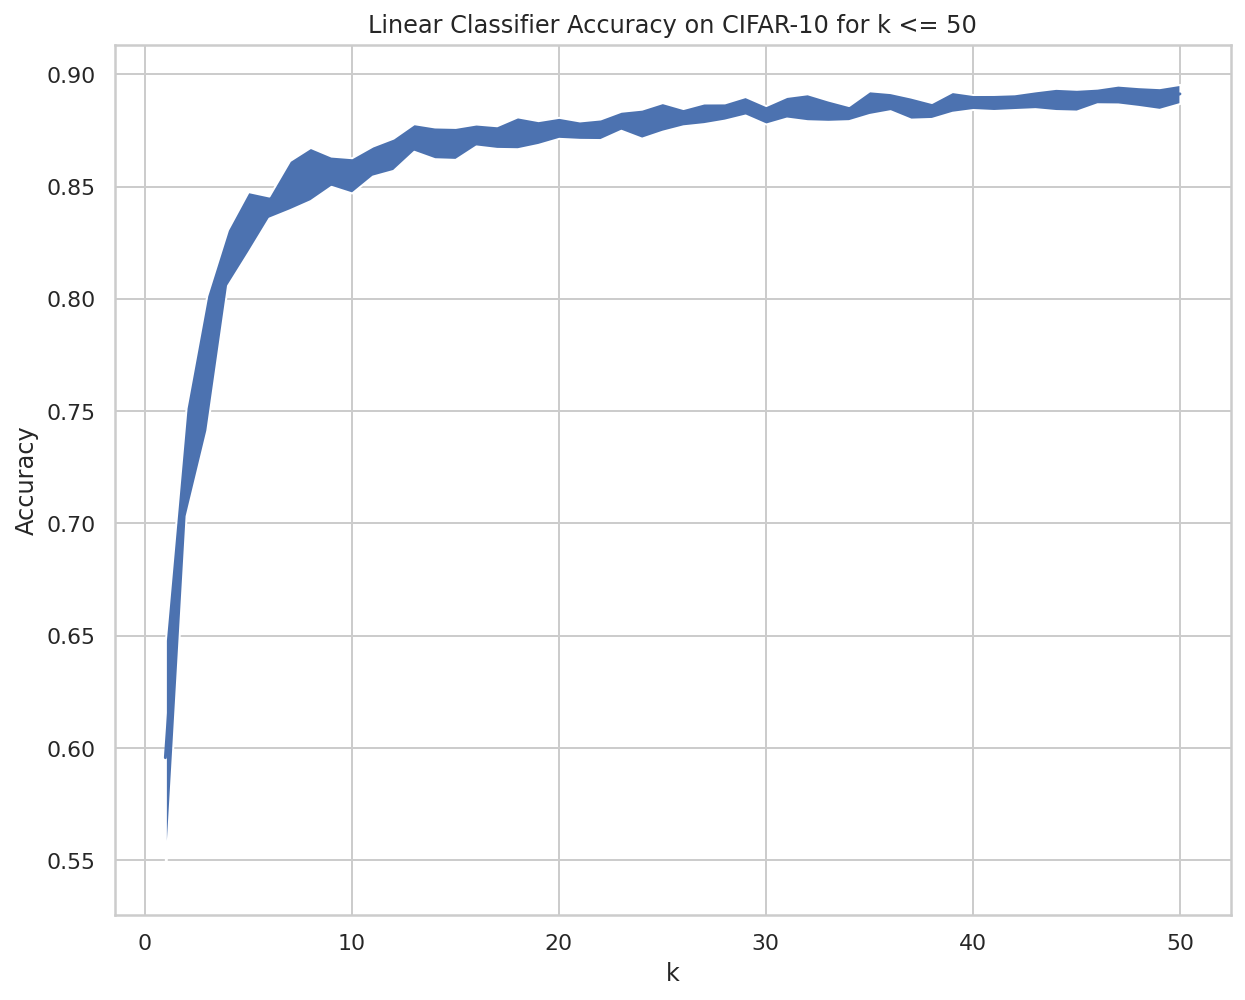

In [75]:
ax = sns.lineplot(x="k", y="Accuracy", data=df)
ax.set_title("Linear Classifier Accuracy on CIFAR-10 for k <= 50")
ax.fill_between(df["k"], y1=df["Accuracy"] - df["std"], y2=df["Accuracy"] + df["std"])